The purpose of this project is to classify text articles into respective categories using a set of available classifiers and observe their performance in terms of accuracy and test time.

The dataset is a real world dataset from sklearn library which comprises around 18,000 newsgroups posts on 20 topics split in train and test subsets. Note that, by default, the text samples contain some message metadata such as 'headers', 'footers' (signatures) and 'quotes' to other posts but are removed in this project.

The data preprocessing includes creation of tdidf vectorizer and also an additional custom feature that might be helpful for classification. 

In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to sys.path if not already there
if project_root not in sys.path:
    sys.path.append(project_root)

In [30]:
from src.data.data_loader import get_top_words, train_data, test_data, data_transformed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
import joblib
from sklearn.metrics import accuracy_score
import time
from src.data.data_loader import get_top_words, train_data, test_data, data_transformed
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

In [3]:
# load train and test data
newsgroups_train = train_data()
newsgroups_test = test_data()

In [4]:
# glimpse of data
print(newsgroups_train.data[1])
print(newsgroups_train.target[1])

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.
4


In [5]:
# test and train splits
df_train = data_transformed(data = newsgroups_train)
df_test = data_transformed(data = newsgroups_test)
df_train

,Target,Text,Target Article Category,Article Length
0,7,I was wondering if anyone out there could enli...,rec.autos,475
1,4,A fair number of brave souls who upgraded thei...,comp.sys.mac.hardware,530
2,4,"well folks, my mac plus finally gave up the gh...",comp.sys.mac.hardware,1659
3,1,\nDo you have Weitek's address/phone number? ...,comp.graphics,95
4,14,"From article <C5owCB.n3p@world.std.com>, by to...",sci.space,448
...,...,...,...,...
11309,13,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,sci.med,1782
11310,4,"I have a (very old) Mac 512k and a Mac Plus, b...",comp.sys.mac.hardware,674
11311,3,I just installed a DX2-66 CPU in a clone mothe...,comp.sys.ibm.pc.hardware,581
11312,1,\nWouldn't this require a hyper-sphere. In 3-...,comp.graphics,311


Top 20 words in train dataset combined are: 
AX AX | one | will | MAX AX | AX MAX | people | use | know | think | U | time | say | make | new | may | problem | well | see | now | system


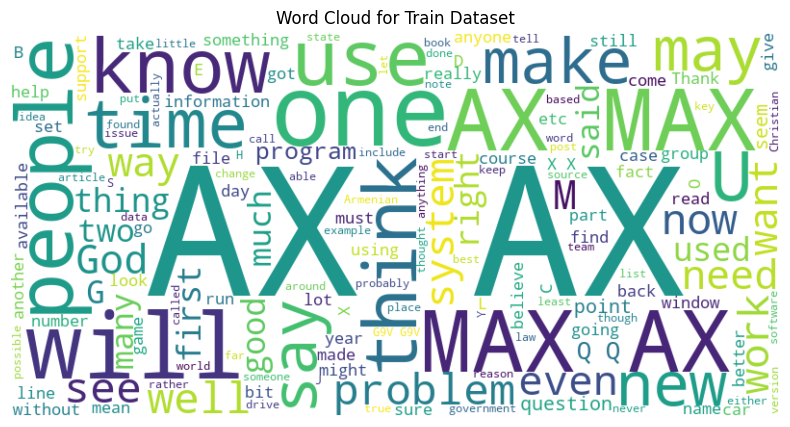

In [6]:
# top 20 words in train and word cloud
words = " ".join(newsgroups_train.data)

top_words_in_train_freq, top_words_in_train = get_top_words(data=words,
                                                            top_n=20)
print('Top 20 words in train dataset combined are: \n{}'.format(top_words_in_train))

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=STOPWORDS,
    min_font_size=10
).generate_from_text(words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Train Dataset')

plt.show()

In [7]:
# top ten words for each article category for all aggregated articles at article category level
aggregations = {
    'Count of Articles': ('Text', 'count'),
    'Average Article Length': ('Article Length', 'mean'),  
    'Std Dev Article Length': ('Article Length', 'std'),
    'Median Article Length': ('Article Length', 'median'),
    'Aggregated Text': ('Text', lambda x: '\n'.join(x)),
}
df1 = df_train.groupby(['Target', 'Target Article Category']).agg(**aggregations) .reset_index()
df1['Top 10 words'] = df1['Aggregated Text'].apply(lambda x: get_top_words(data=x, top_n=10)[1])
df1

,Target,Target Article Category,Count of Articles,Average Article Length,Std Dev Article Length,Median Article Length,Aggregated Text,Top 10 words
0,0,alt.atheism,480,1156.543750,3413.015911,529.0,\nDon't be so sure. Look what happened to Jap...,God | one | people | will | think | atheist | ...
1,1,comp.graphics,584,1032.464041,4656.998939,375.0,\nDo you have Weitek's address/phone number? ...,image | file | will | program | use | JPEG | s...
2,2,comp.os.ms-windows.misc,591,2242.323181,9599.637340,400.0,I have win 3.0 and downloaded several icons an...,AX AX | M | MAX AX | AX MAX | G | Q Q | L | C ...
3,3,comp.sys.ibm.pc.hardware,590,794.003390,2112.623090,458.0,...,drive | SCSI | one | use | system | will | car...
4,4,comp.sys.mac.hardware,578,636.351211,1995.491864,394.0,A fair number of brave souls who upgraded thei...,Mac | one | Apple | problem | use | drive | wi...
5,5,comp.windows.x,593,1544.603710,6090.300692,497.0,QUESTION:\n What is the EXACT entry (paramete...,X X | X | use | program | will | window | widg...
6,6,misc.forsale,585,687.249573,1212.084621,408.0,Reduced Prices! \nI have a list of things fors...,sale | new | one | DOS | game | will | price |...
7,7,rec.autos,594,680.920875,1481.324505,380.5,I was wondering if anyone out there could enli...,car | will | one | time | engine | good | thin...
8,8,rec.motorcycles,598,621.665552,1563.394799,361.5,I have a line on a Ducati 900GTS 1978 model wi...,bike | one | know | will | ride | motorcycle |...
9,9,rec.sport.baseball,597,708.033501,1178.888744,332.0,Doug Roberts - Ken Hill for NL MVP!!\n\t ...,game | team | year | one | player | think | wi...


Here it can be seen that for category **comp.os.ms-windows.misc** and **comp.windows.x** we have words **AX AX | M | MAX AX | XX | X** occurring the most. They seem like some form of encoded words and not plain english words. It would likely make sense to remove such encoded words or classify them under STOP WORDS, but we shall retain them as it is difficult to locate such words accurately in train datasets and such occurences might be common in test datasets as well. This potentially may be helpful in classification.

Here we can create length of article as a potential feature. However, looking at the standard deviation being almost as twice or more as big as the mean might indicate that length of article may not exactly be a discriminative feature for classifiers. However, to confirm our hypothesis we shall fit two versions for each classifier we fit, both with and without the length of article feature.

Looking at the count of articles, our class **target article category** seems to be reasonably balanced.

Various models have been fitted in a separate notebook and best parameters have been obtained using random search cross validation.

Models are saved in a file along with metadata information like CV training times and training best accuracies. Models with * (asterisk) are models with extra custom feature.

In [8]:
# import saved models
models_filename = project_root + r'\notebooks\multiple_classification_models.joblib'
trained_models = joblib.load(models_filename)

In [11]:
# predict saved models on test datasets and append important metadata info
for model in trained_models:
    best_model = model['model'].best_estimator_
    t0 = time.perf_counter()
    y_pred = best_model.predict(df_test)
    model['test time'] = time.perf_counter() - t0
    model['test accuracy'] = accuracy_score(df_test['Target Article Category'],y_pred)
    print('Model: {} | Accuracy: {}'.format(model['metadata']['model_type'], model['metadata']['CV_score_best_model']))

Model: *Complement Naive Bayes | Accuracy: 0.7592376574213319
Model: Complement Naive Bayes | Accuracy: 0.7590609399742837
Model: *Logistic Regression | Accuracy: 0.7564086545054745
Model: Logistic Regression | Accuracy: 0.7564970327644227
Model: *SVM | Accuracy: 0.7564970327644227
Model: SVM | Accuracy: 0.7610936008592462
Model: *KNN | Accuracy: 0.163514469693329
Model: KNN | Accuracy: 0.17129238161435276


In [ ]:
# plot test metadata for classifiers
plt.figure(figsize=(15, 6))

training_times = [entry['test time'] for entry in trained_models]
accuracies = [entry['test accuracy'] for entry in trained_models]
model_labels = [entry['metadata']['model_type'] for entry in trained_models]
    
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, (time, accuracy) in enumerate(zip(training_times, accuracies)):
        plt.scatter(time, accuracy, s=100, alpha=0.7, color=colors[i % len(colors)], label=model_labels[i])

plt.title('Model Accuracy vs Testing Time')
plt.xlabel('Testing Time (seconds)')
plt.ylabel('Accuracy Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='best')
plt.show()

The above chart displays Classification Accuracy vs Testing time for different models. Following observations are made:

* Complement Naive Bayes works the best in terms of accuracy and time.
* Logistic and SVM are similar in both accuracy scores and test time.
* KNN performs the worst in testing time and accuracy. This arises due to curse of dimensionality and calculating distances.
* There is a hardly any increase in accuracy upon addition of the length of text as a new feature across different models. Hence, that feature can be eliminated.

In [15]:
# best model performance
best_pipeline = trained_models[0]['model'].best_estimator_
y_pred = best_pipeline.predict(df_test)
print(classification_report(df_test['Target Article Category'], y_pred))

                          precision    recall  f1-score   support

             alt.atheism       0.36      0.48      0.41       319
           comp.graphics       0.71      0.70      0.71       389
 comp.os.ms-windows.misc       0.54      0.62      0.58       394
comp.sys.ibm.pc.hardware       0.66      0.68      0.67       392
   comp.sys.mac.hardware       0.75      0.72      0.73       385
          comp.windows.x       0.80      0.75      0.77       395
            misc.forsale       0.76      0.72      0.74       390
               rec.autos       0.80      0.72      0.76       396
         rec.motorcycles       0.79      0.78      0.79       398
      rec.sport.baseball       0.89      0.84      0.86       397
        rec.sport.hockey       0.84      0.92      0.88       399
               sci.crypt       0.80      0.79      0.80       396
         sci.electronics       0.67      0.55      0.60       393
                 sci.med       0.79      0.80      0.79       396
         

Some important observations that coud be made here are:
* alt.atheism and tale.religion.misc have a very low precision and recall. This could occur from the fact that both consists of similar words pertaining to religion and theology thus making it difficult to classify accurately.